In [12]:
import os
os.environ['HDF5_USE_FILE_LOCKING']='FALSE'

In [2]:
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import os
import pandas as pd
import h5py
import h5netcdf
from netCDF4 import Dataset, MFDataset
from scipy.io import savemat, loadmat

In [3]:
prefix = '/data/rong4/Data/'
prefix2 = '/data/rong3/achang1029/'
prefix3 = '/data/rong1/achang1029/'
prefix4 = '/data/amazon1/achang1029/'

VCF Data

In [20]:
vcf = np.load(prefix2 + "SA_output/percent_tree_cover_2000-2023.npy")

In [21]:
vcf.shape

(24, 240, 360)

In [22]:
modis_grid_lons = np.zeros((240, 360))
for i in range(240):
    modis_grid_lons[i] = np.arange(-70+1/24, -40, 1/12) / np.cos(np.radians(np.arange(-1/24, -20, -1/12)[i]))
modis_grid_lats = np.repeat(np.arange(-1/24, -20, -1/12), 360).reshape(240, 360)

modis_grid_lons_edges = np.zeros((241, 361))
for i in range(241):
    modis_grid_lons_edges[i] = np.arange(-70, -40+1/24, 1/12) / np.cos(np.radians(np.arange(0, -20-1/24, -1/12)[i]))
modis_grid_lats_edges = np.repeat(np.arange(0, -20-1/24, -1/12), 361).reshape(241, 361)

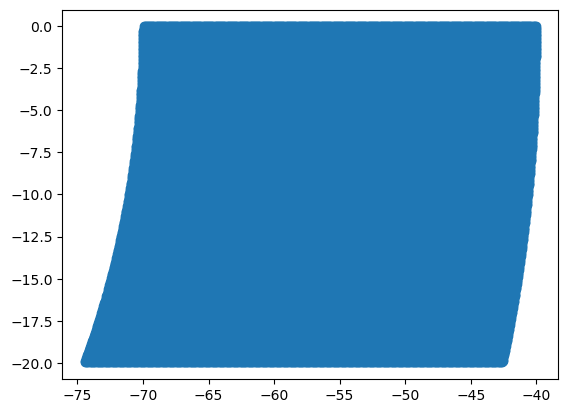

In [23]:
plt.scatter(modis_grid_lons, modis_grid_lats)

In [24]:
lon_out_b = np.linspace(-70, -40, 121)  # bounds
lon_out = 0.5 * (lon_out_b[1:] + lon_out_b[:-1])  # centers

lat_out_b = np.linspace(0, -20, 81)
lat_out = 0.5 * (lat_out_b[1:] + lat_out_b[:-1])

In [7]:
grid_in = {"lon": modis_grid_lons, "lat": modis_grid_lats, "lon_b": modis_grid_lons_edges, "lat_b": modis_grid_lats_edges}

grid_out = {"lon": lon_out, "lat": lat_out, "lon_b": lon_out_b, "lat_b": lat_out_b}

NameError: name 'modis_grid_lons' is not defined

In [26]:
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_240x360_80x120.nc 
Reuse pre-computed weights? False 
Input grid shape:           (np.int32(240), np.int32(360)) 
Output grid shape:          (np.int32(80), np.int32(120)) 
Periodic in longitude?      False

In [27]:
vcf_regridded = regridder(vcf)

In [30]:
np.save(prefix2 + "SA_output/percent_tree_cover_2000-2023_regridded", vcf_regridded)

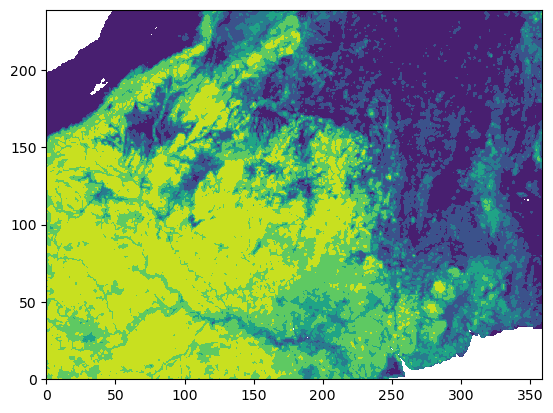

In [28]:
plt.contourf(vcf[0])

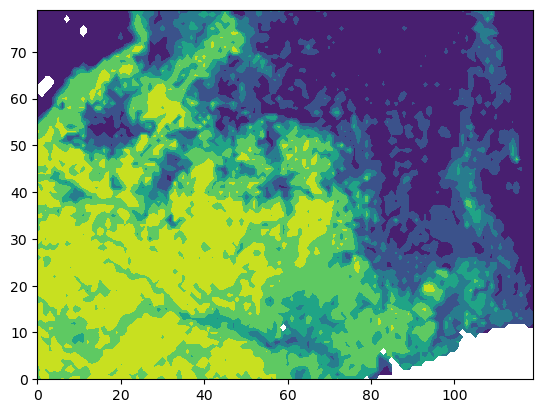

In [29]:
plt.contourf(vcf_regridded[0])

CMIP6 Ensembles

In [4]:
lon_out_b = np.linspace(0, 360, 361)  # bounds
lon_out = 0.5 * (lon_out_b[1:] + lon_out_b[:-1])  # centers

lat_out_b = np.linspace(90, -90, 181)
lat_out = 0.5 * (lat_out_b[1:] + lat_out_b[:-1])

In [5]:
print(lon_out[-85:-30])
print(lat_out[75:125])

[275.5 276.5 277.5 278.5 279.5 280.5 281.5 282.5 283.5 284.5 285.5 286.5
 287.5 288.5 289.5 290.5 291.5 292.5 293.5 294.5 295.5 296.5 297.5 298.5
 299.5 300.5 301.5 302.5 303.5 304.5 305.5 306.5 307.5 308.5 309.5 310.5
 311.5 312.5 313.5 314.5 315.5 316.5 317.5 318.5 319.5 320.5 321.5 322.5
 323.5 324.5 325.5 326.5 327.5 328.5 329.5]
[ 14.5  13.5  12.5  11.5  10.5   9.5   8.5   7.5   6.5   5.5   4.5   3.5
   2.5   1.5   0.5  -0.5  -1.5  -2.5  -3.5  -4.5  -5.5  -6.5  -7.5  -8.5
  -9.5 -10.5 -11.5 -12.5 -13.5 -14.5 -15.5 -16.5 -17.5 -18.5 -19.5 -20.5
 -21.5 -22.5 -23.5 -24.5 -25.5 -26.5 -27.5 -28.5 -29.5 -30.5 -31.5 -32.5
 -33.5 -34.5]


In [8]:
# model_names = cmip6_model_list.to_dict()['Model']
# ensemble_ids = cmip6_model_list.to_dict()['Ensemble']

In [6]:
model_list = ['MPI-ESM1-2-HR',
'MPI-ESM1-2-LR',
'MIROC6',
#'FGOALS-g3', missing a few years in ssp2 and ssp5 data
'ACCESS-CM2', #regridded in /rong3
'ACCESS-ESM1-5', #regridded in /rong3
'CMCC-ESM2',
'CanESM5',
#'EC-Earth3', #missing a lot of ssp 1 and 2 data
'GFDL-ESM4',
'HadGEM3-GC31-LL',
'INM-CM4-8',
'INM-CM5-0',
'IPSL-CM6A-LR',
'KACE-1-0-G',
#'EC-Earth3-Veg', #missing a lot of ssp 1 and 2 data
#'AWI-CM-1-1-MR', #NOTE: hurs historical runs are based on 1000 hPa, not the surface since that is what was available
'EC-Earth3-Veg-LR',
'MRI-ESM2-0',
'NorESM2-LM',
'NorESM2-MM',
#'EC-Earth3-CC', #missing ssp1 data
#'BCC-CSM2-MR', #NOTE: hurs ssp runs are based on 1000 hPa, not the surface since that is what was available
'CMCC-CM2-SR5',
#'NESM3', #NOTE: hurs data for ssp runs based on 1000 hPa, not the surface since that is what was available
#'KIOST-ESM', #missing temperature data
#'IITM-ESM', #missing a lot of data
'TaiESM1']
#'CAS-ESM2-0'] #missing ssp5 data
#'FIO-ESM-2-0'] data still downloading, might not exist
#'CanESM5-1', #missing various ssp1, 2 data
#'CIESM', #missing humidity data
#'AWI-ESM-1-1-LR', #missing all ssp data
#'MPI-ESM-1-2-HAM', #missing all ssp data
#'EC-Earth3-AerChem', #missing all ssp data
#'FGOALS-f3-L', #missing temperature data
#'GISS-E2-1-G', #missing all ssp data
#'SAM0-UNICON', #missing all ssp data
#'GISS-E2-2-G', #missing all ssp data
#'BCC-ESM1', #missing all ssp data
#'CESM2-WACCM', #missing a lot of data, can't find online
#'IPSL-CM5A2-INCA', #missing a lot of data
#'IPSL-CM6A-LR-INCA', #missing all ssp data
#'GISS-E2-1-G-CC', #missing all ssp data
#'GISS-E2-1-H', #missing all ssp data
#'GISS-E2-2-H', #missing all ssp data
#'CESM2', #these models are all missing data
# 'AWI-ESM-1-REcoM',
# 'CMCC-CM2-HR4',
# 'E3SM-1-0',
# 'NorCPM1',
# 'CESM2-FV2',
# 'CESM2-WACCM-FV2',
# 'E3SM-1-1-ECA',
# 'E3SM-2-0',
# 'E3SM-2-0-NARRM',
# 'E3SM-2-1',
# 'MCM-UA-1-0']

In [7]:
def np_to_xr(ds):
    if ds.shape[0] == 45*12: #ERA5: 1979-2023
        time_array = np.arange(129*12, 174*12)
    elif ds.shape[0] == 165*12: #CMIP6 Historical: 1850-2014
        time_array = np.arange(165*12)
    else: #CMIP6 Projection: 2015 after
        time_array = np.arange(165*12, 165*12 + ds.shape[0])
    
    lat_array = np.linspace(90, -90, ds.shape[1])
    lon_array = np.linspace(0, 360, ds.shape[2])
    
    df = xr.DataArray(ds, coords={'time':time_array, 'lat':lat_array, 'lon':lon_array}, dims=['time', 'lat', 'lon'])

In [43]:
#MONTHLY DATA
for experiment in ['historical', 'ssp126', 'ssp245', 'ssp585']:
    for model in model_list:
        ens = 'r1i1p1f1'

        grid_out = {"lon": lon_out, "lat": lat_out}

        try:
            print(model, experiment)
            
#             if experiment == 'ssp126': #The original ssp126 files give HDF errors when reading in this environment
#                 hurs_file = np.load(prefix2 + 'CMIP6/ensembles/ssp126_raw/npy_files/hurs_' + model + '_' + experiment + '_' + ens + '.npy')
#                 tasmin_file = np.load(prefix2 + 'CMIP6/ensembles/ssp126_raw/npy_files/tasmin_' + model + '_' + experiment + '_' + ens + '.npy')
#                 tasmax_file = np.load(prefix2 + 'CMIP6/ensembles/ssp126_raw/npy_files/tasmax_' + model + '_' + experiment + '_' + ens + '.npy')

#                 lon_in_b = np.linspace(0, 360, hurs_file.shape[2])  # bounds
#                 lon_in = 0.5 * (lon_in_b[1:] + lon_in_b[:-1])  # centers

#                 lat_in_b = np.linspace(-90, 90, hurs_file.shape[1])
#                 lat_in = 0.5 * (lat_in_b[1:] + lat_in_b[:-1])

#                 grid_in = {"lon": lon_in_b, "lat": lat_in_b}
#                 regridder = xe.Regridder(grid_in, grid_out, "bilinear")

#             else:
            #beware of datasets that have historical runs to 2016
            hurs_file = xr.open_mfdataset(prefix4 + 'CMIP6/r1i1p1f1_monthly/hurs_Amon_' + model + '_' + experiment + '_*' + ens + '*[12][0189][0-9][0-9]01*.nc', use_cftime=True)['hurs']
            tasmin_file = xr.open_mfdataset(prefix4 + 'CMIP6/r1i1p1f1_monthly/tasmin_Amon_' + model + '_' + experiment + '_*' + ens + '*[12][0189][0-9][0-9]01*.nc', use_cftime=True)['tasmin']
            tasmax_file = xr.open_mfdataset(prefix4 + 'CMIP6/r1i1p1f1_monthly/tasmax_Amon_' + model + '_' + experiment + '_*' + ens + '*[12][0189][0-9][0-9]01*.nc', use_cftime=True)['tasmax']
            
#             if hurs_file.shape[1] == 192: #issues with 192*288 for some reason. regrid later
#                 print("Issues with regridding.")
#                 continue
            
#             if hurs_file.shape[1] == 160: #issues with 160*320 for some reason. regrid later
#                 print("Issues with regridding.")
#                 continue
            
            if 'height' in hurs_file.coords:
                hurs_file = hurs_file.drop_vars("height")
                tasmin_file = tasmin_file.drop_vars("height")
                tasmax_file = tasmax_file.drop_vars("height")
            
            if experiment == 'historical':
                hurs_file = hurs_file[:165*12]
                tasmin_file = tasmin_file[:165*12]
                tasmax_file = tasmax_file[:165*12]
                
                assert hurs_file.shape[0] == 165*12
                assert tasmin_file.shape[0] == 165*12
                assert tasmax_file.shape[0] == 165*12
            else:
                hurs_file = hurs_file[:86*12]
                tasmin_file = tasmin_file[:86*12]
                tasmax_file = tasmax_file[:86*12]
                
                assert hurs_file.shape[0] == 86*12
                assert tasmin_file.shape[0] == 86*12
                assert tasmax_file.shape[0] == 86*12
            
            regridder = xe.Regridder(hurs_file, grid_out, "bilinear", periodic=True)

            hurs_regridded = regridder(hurs_file)
            tasmin_regridded = regridder(tasmin_file)
            tasmax_regridded = regridder(tasmax_file)

            np.save(prefix4 + 'CMIP6/regridded/monthly/hurs_Amon_' + model + '_' + experiment + '_' + ens + '_regridded', hurs_regridded)
            np.save(prefix4 + 'CMIP6/regridded/monthly/tasmin_Amon_' + model + '_' + experiment + '_' + ens + '_regridded', tasmin_regridded)
            np.save(prefix4 + 'CMIP6/regridded/monthly/tasmax_Amon_' + model + '_' + experiment + '_' + ens + '_regridded', tasmax_regridded)

        except OSError as e:
            print(e)
        except AssertionError:
            print("Time dimension mismatch. Missing files from 1850-2100.")
            continue

MPI-ESM1-2-HR ssp126
MPI-ESM1-2-LR ssp126
MIROC6 ssp126
FGOALS-g3 ssp126
ACCESS-CM2 ssp126
ACCESS-ESM1-5 ssp126
CMCC-ESM2 ssp126
CanESM5 ssp126
EC-Earth3 ssp126
GFDL-ESM4 ssp126
INM-CM4-8 ssp126
INM-CM5-0 ssp126
IPSL-CM6A-LR ssp126
EC-Earth3-Veg ssp126
EC-Earth3-Veg-LR ssp126
MRI-ESM2-0 ssp126
CMCC-CM2-SR5 ssp126
CAS-ESM2-0 ssp126
FIO-ESM-2-0 ssp126
MPI-ESM1-2-HR ssp245
MPI-ESM1-2-LR ssp245
MIROC6 ssp245
FGOALS-g3 ssp245
ACCESS-CM2 ssp245
ACCESS-ESM1-5 ssp245
CMCC-ESM2 ssp245
CanESM5 ssp245
EC-Earth3 ssp245
GFDL-ESM4 ssp245
INM-CM4-8 ssp245
INM-CM5-0 ssp245
IPSL-CM6A-LR ssp245
EC-Earth3-Veg ssp245
EC-Earth3-Veg-LR ssp245
MRI-ESM2-0 ssp245
CMCC-CM2-SR5 ssp245
CAS-ESM2-0 ssp245
FIO-ESM-2-0 ssp245
MPI-ESM1-2-HR ssp585
MPI-ESM1-2-LR ssp585
MIROC6 ssp585
FGOALS-g3 ssp585
ACCESS-CM2 ssp585
ACCESS-ESM1-5 ssp585
CMCC-ESM2 ssp585
CanESM5 ssp585
EC-Earth3 ssp585
GFDL-ESM4 ssp585
INM-CM4-8 ssp585
INM-CM5-0 ssp585
IPSL-CM6A-LR ssp585
EC-Earth3-Veg ssp585
EC-Earth3-Veg-LR ssp585
MRI-ESM2-0 ssp585
C

CMIP6 Daily Data

In [8]:
def np_to_xr_daily(ds):
    if ds.shape[0] == 45*365: #ERA5: 1979-2023
        time_array = np.arange(129*365, 174*365)
    elif ds.shape[0] == 165*365: #CMIP6 Historical: 1850-2014
        time_array = np.arange(165*365)
    else: #CMIP6 Projection: 2015 after
        time_array = np.arange(165*365, 165*365 + ds.shape[0])
    
    lat_array = np.linspace(90, -90, ds.shape[1])
    lon_array = np.linspace(0, 360, ds.shape[2])
    
    df = xr.DataArray(ds, coords={'time':time_array, 'lat':lat_array, 'lon':lon_array}, dims=['time', 'lat', 'lon'])

In [14]:
#DAILY DATA
for experiment in ['historical', 'ssp126', 'ssp245', 'ssp585']:
    for model in model_list:
        if model in ['HadGEM3-GC31-LL', 'KACE-1-0-G']:
            if model == 'HadGEM3-GC31-LL':
                ens = 'r1i1p1f3'
            else:
                ens = 'r1i1p1f1'
            align_on = 'year'
            num_days = 360
        else:
            ens = 'r1i1p1f1'
            align_on = None
            num_days = 365
                
        grid_out = {"lon": lon_out, "lat": lat_out, "lon_b": lon_out_b, "lat_b": lat_out_b}

        try:
            print(model, experiment)
            if os.path.exists(prefix4 + 'CMIP6/regridded/daily/hurs_day_' + model + '_' + experiment + '_' + ens + '_regridded.npy'):
                if os.path.exists(prefix4 + 'CMIP6/regridded/daily/tasmin_day_' + model + '_' + experiment + '_' + ens + '_regridded.npy'):
                    if os.path.exists(prefix4 + 'CMIP6/regridded/daily/tasmax_day_' + model + '_' + experiment + '_' + ens + '_regridded.npy'):                
                        print("Files already regridded.")
                        continue
            #regex limits time period to 2100
            hurs_file = xr.open_mfdataset(prefix4 + 'CMIP6/r1i1p1f1_daily/hurs_day_' + model + '_' + experiment + '_*' + ens + '*[12][0189][0-9][0-9]0101*.nc', use_cftime=True).convert_calendar('noleap', 'time', align_on)['hurs']
            tasmin_file = xr.open_mfdataset(prefix4 + 'CMIP6/r1i1p1f1_daily/tasmin_day_' + model + '_' + experiment + '_*' + ens + '*[12][0189][0-9][0-9]0101*.nc', use_cftime=True).convert_calendar('noleap', 'time', align_on)['tasmin']
            tasmax_file = xr.open_mfdataset(prefix4 + 'CMIP6/r1i1p1f1_daily/tasmax_day_' + model + '_' + experiment + '_*' + ens + '*[12][0189][0-9][0-9]0101*.nc', use_cftime=True).convert_calendar('noleap', 'time', align_on)['tasmax']

            if 'height' in hurs_file.coords:
                hurs_file = hurs_file.drop_vars("height")
                tasmin_file = tasmin_file.drop_vars("height")
                tasmax_file = tasmax_file.drop_vars("height")
            
            if experiment == 'historical':
                hurs_file = hurs_file[:165*num_days]
                tasmin_file = tasmin_file[:165*num_days]
                tasmax_file = tasmax_file[:165*num_days]
                
                assert hurs_file.shape[0] == 165*num_days
                assert tasmin_file.shape[0] == 165*num_days
                assert tasmax_file.shape[0] == 165*num_days
            else:
                hurs_file = hurs_file[:86*num_days]
                tasmin_file = tasmin_file[:86*num_days]
                tasmax_file = tasmax_file[:86*num_days]
                
                assert hurs_file.shape[0] == 86*num_days
                assert tasmin_file.shape[0] == 86*num_days
                assert tasmax_file.shape[0] == 86*num_days
            
            regridder = xe.Regridder(hurs_file, grid_out, "bilinear")

            hurs_regridded = regridder(hurs_file)
            tasmin_regridded = regridder(tasmin_file)
            tasmax_regridded = regridder(tasmax_file)

            np.save(prefix4 + 'CMIP6/regridded/daily/hurs_day_' + model + '_' + experiment + '_' + ens + '_regridded', hurs_regridded)
            np.save(prefix4 + 'CMIP6/regridded/daily/tasmin_day_' + model + '_' + experiment + '_' + ens + '_regridded', tasmin_regridded)
            np.save(prefix4 + 'CMIP6/regridded/daily/tasmax_day_' + model + '_' + experiment + '_' + ens + '_regridded', tasmax_regridded)
#                 savemat(prefix2 + 'CMIP6/regridded/daily/mat_files/hurs_day_' + model + '_' + experiment + '_' + ens + '_regridded.mat', {'hurs':hurs_regridded.T})
#                 savemat(prefix2 + 'CMIP6/regridded/daily/mat_files/tasmin_day_' + model + '_' + experiment + '_' + ens + '_regridded.mat', {'tasmin':tasmin_regridded.T})
#                 savemat(prefix2 + 'CMIP6/regridded/daily/mat_files/tasmax_day_' + model + '_' + experiment + '_' + ens + '_regridded.mat', {'tasmax':tasmax_regridded.T})

        except OSError as e:
            print(e)
#             print(model, experiment, ens, "At least one missing ensemble. Continuing to next combination...")
            continue
        except ValueError as e:
            print(e)
            continue
        except AssertionError:
            print("Time dimension mismatch. Missing files from 1850-2100.")
            continue

MPI-ESM1-2-HR historical
Files already regridded.
MPI-ESM1-2-LR historical
Files already regridded.
MIROC6 historical
Files already regridded.
ACCESS-CM2 historical
Files already regridded.
ACCESS-ESM1-5 historical
Files already regridded.
CMCC-ESM2 historical
Files already regridded.
CanESM5 historical
Files already regridded.
GFDL-ESM4 historical
Files already regridded.
HadGEM3-GC31-LL historical
Files already regridded.
INM-CM4-8 historical
Files already regridded.
INM-CM5-0 historical
Files already regridded.
IPSL-CM6A-LR historical
Files already regridded.
KACE-1-0-G historical
EC-Earth3-Veg-LR historical
Files already regridded.
MRI-ESM2-0 historical
Files already regridded.
NorESM2-LM historical
Files already regridded.
NorESM2-MM historical
CMCC-CM2-SR5 historical
Files already regridded.
TaiESM1 historical
MPI-ESM1-2-HR ssp126
Files already regridded.
MPI-ESM1-2-LR ssp126
Files already regridded.
MIROC6 ssp126
Files already regridded.
ACCESS-CM2 ssp126
no files to open
ACCESS

In [19]:
#Test to see what files are missing or corrupt
for variable in ['hurs', 'tasmax', 'tasmin']:
    for experim in ['ssp126', 'ssp245', 'ssp585']:
#         if experim == 'historical':
#             yrs = np.arange(1850, 2015)
#         else:
#             yrs = np.arange(2015, 2101)
        yrs = [2015, 2050]
        end_yrs = [2049, 2100]
        for i in np.arange(2):
            try:
                xr.open_dataset(prefix4 + 'CMIP6/r1i1p1f1_daily/'+variable+'_day_HadGEM3-GC31-LL_'+experim+'_r1i1p1f3_gn_'+str(yrs[i])+'0101-'+str(end_yrs[i])+'1230.nc', use_cftime=True, engine='netcdf4')[variable]
            except OSError as e:
                print(e)

CMIP6 SST DATA

In [13]:
sst_files = [f for f in os.listdir("/data/amazon1/achang1029/CMIP6/ensembles_monthly") if os.path.isfile(os.path.join("/data/amazon1/achang1029/CMIP6/ensembles_monthly", f))]

In [22]:
sst_files[0][0:3]

'tos'

In [24]:
#SST MONTHLY DATA
for f in sst_files: #Add back the other experiments later
    try:
        print(f)
        if f[0:3] != 'tos':
            continue
        parameters = f.split("_")
        model = parameters[2]
        experiment = parameters[3]
        ens = parameters[4]
        grid = parameters[5]
        
        if os.path.exists(prefix4 + 'CMIP6/regridded/monthly/tos_Omon_' + model + '_' + experiment + '_' + ens + '_regridded_monthly.npy'):
            print("Files already regridded.")
            continue
            
        #Check if there's a hist-nat ensemble for the same run
        if not os.path.exists(prefix4 + 'CMIP6/regridded/monthly/tos_Omon_' + model + '_hist-nat_' + ens + '_regridded_monthly.npy'):
            print("Ensemble doesn't have a hist-nat run. Skipping...")
            continue
#         if grid != 'gn':
#             print("Grid not gn. Skipping...")
#             continue
        #tos = SSTs
        tos_file = xr.open_mfdataset(prefix4 + 'CMIP6/ensembles_monthly/tos_Omon_' + model + '*' + experiment + '_*' + ens + '_' + grid + '*.nc')
#         print(tos_file)
#         if "lat" not in tos_file.dims:
#             if "lat" in tos_file.coords:
#                 tos_file = tos_file.rename({'lat': 'latitude', 'lon': 'longitude'})
#             if "j" in tos_file.dims:
#                 tos_file = tos_file.rename({'j': 'lat', 'i': 'lon'})
#             elif "y" in tos_file.dims:
#                 tos_file = tos_file.rename({'y': 'lat', 'x': 'lon'})

        #regrid to 1x1 degree resolution
        grid_out = xe.util.grid_global(1, 1)

        regridder = xe.Regridder(tos_file, grid_out, "bilinear", ignore_degenerate=True)

        #temporary fix from https://github.com/pangeo-data/xESMF/issues/315#issuecomment-2197688299
        regridder.shape_in = tuple(map(int, regridder.shape_in))
        regridder.shape_out = tuple(map(int, regridder.shape_out))

        tos_regridded = regridder(tos_file['tos'])

        np.save(prefix4 + 'CMIP6/regridded/monthly/tos_Omon_' + model + '_' + experiment + '_' + ens + '_regridded_monthly', tos_regridded)

        print(model, experiment, ens)

    except OSError:
        print(model, experiment, ens, "not found. Continuing to next combination...")
        continue
    except ValueError:
        print("ESGF Regridding error. Continuing to next combination...")
        continue
    except MemoryError:
        print("Huge Memory usage in this file. Try reducing file size. Continuing...")

tos_Omon_EC-Earth3_historical_r130i1p1f1_gn_199601-199612.nc
Files already regridded.
tos_Omon_EC-Earth3-Veg_historical_r1i1p1f1_gn_192901-192912.nc
Files already regridded.
tos_Omon_EC-Earth3_historical_r131i1p1f1_gn_198001-198012.nc
Files already regridded.
tos_Omon_EC-Earth3_historical_r2i1p1f1_gr_194001-194012.nc
Files already regridded.
tos_Omon_EC-Earth3_historical_r123i1p1f1_gn_200101-200112.nc
Files already regridded.
tos_Omon_CESM2_historical_r2i1p1f1_gn_185001-201412.nc


/data/rong3/achang1029/anaconda3/envs/xesmf_env/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tos' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/data/rong3/achang1029/anaconda3/envs/xesmf_env/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tos' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/data/rong3/achang1029/anaconda3/envs/xesmf_env/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tos' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/data/rong3/achang1029/anaconda3/envs/xesmf_env/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tos' has multiple fill values {

ESGF Regridding error. Continuing to next combination...
tos_Omon_GISS-E2-2-H_historical_r1i1p1f1_gn_197601-200012.nc
Files already regridded.
tos_Omon_EC-Earth3-Veg_historical_r3i1p1f1_gn_186901-186912.nc
Files already regridded.
tos_Omon_EC-Earth3-Veg_historical_r2i1p1f1_gn_191301-191312.nc
Files already regridded.
tos_Omon_EC-Earth3-Veg_historical_r2i1p1f1_gn_195201-195212.nc
Files already regridded.
tos_Omon_EC-Earth3-Veg_historical_r11i1p1f1_gn_189401-189412.nc
Files already regridded.
tos_Omon_MIROC6_hist-nat_r3i1p1f1_gn_195001-202012.nc
Files already regridded.
tos_Omon_EC-Earth3-Veg_historical_r3i1p1f1_gn_194401-194412.nc
Files already regridded.
tos_Omon_EC-Earth3_historical_r2i1p1f1_gr_190101-190112.nc
Files already regridded.
tos_Omon_EC-Earth3_historical_r144i1p1f1_gn_197801-197812.nc
Files already regridded.
tos_Omon_EC-Earth3_historical_r115i1p1f1_gn_197501-197512.nc
Files already regridded.
tos_Omon_EC-Earth3-Veg_historical_r1i1p1f1_gn_196801-196812.nc
Files already regr

/data/rong3/achang1029/anaconda3/envs/xesmf_env/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tos' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/data/rong3/achang1029/anaconda3/envs/xesmf_env/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tos' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/data/rong3/achang1029/anaconda3/envs/xesmf_env/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tos' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/data/rong3/achang1029/anaconda3/envs/xesmf_env/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tos' has multiple fill values {

ESGF Regridding error. Continuing to next combination...
tos_Omon_EC-Earth3_historical_r120i1p1f1_gn_200101-200112.nc
Ensemble doesn't have a hist-nat run. Skipping...
tos_Omon_EC-Earth3-Veg_historical_r11i1p1f1_gn_198301-198312.nc
Files already regridded.
tos_Amon_EC-Earth3_historical_r2i1p1f1_gr_200401-200412.nc
Files already regridded.
tos_Omon_EC-Earth3-Veg_historical_r3i1p1f1_gn_185301-185312.nc
Files already regridded.
tos_Omon_SAM0-UNICON_historical_r1i1p1f1_gn_190001-190912.nc
Ensemble doesn't have a hist-nat run. Skipping...
tos_Omon_EC-Earth3-AerChem_historical_r1i1p1f1_gn_201101-201112.nc
Ensemble doesn't have a hist-nat run. Skipping...
tos_Omon_EC-Earth3_historical_r126i1p1f1_gn_198801-198812.nc
Files already regridded.
tos_Omon_ICON-ESM-LR_historical_r1i1p1f1_gn_197001-197912.nc
Ensemble doesn't have a hist-nat run. Skipping...
tos_Omon_CNRM-ESM2-1_historical_r9i1p1f2_gn_185001-201412.nc
Ensemble doesn't have a hist-nat run. Skipping...
tos_Omon_EC-Earth3-Veg_historical_r

/data/rong3/achang1029/anaconda3/envs/xesmf_env/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tos' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/data/rong3/achang1029/anaconda3/envs/xesmf_env/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tos' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/data/rong3/achang1029/anaconda3/envs/xesmf_env/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tos' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/data/rong3/achang1029/anaconda3/envs/xesmf_env/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tos' has multiple fill values {

ESGF Regridding error. Continuing to next combination...
tos_Omon_EC-Earth3_historical_r140i1p1f1_gn_197001-197012.nc
Ensemble doesn't have a hist-nat run. Skipping...
tos_Omon_TaiESM1_historical_r1i1p1f1_gn_190301-190312.nc
Files already regridded.
tos_Omon_EC-Earth3-Veg_historical_r12i1p1f1_gr_198301-198312.nc
Ensemble doesn't have a hist-nat run. Skipping...
tos_Omon_TaiESM1_historical_r1i1p1f1_gn_194201-194212.nc
Files already regridded.
tos_Omon_EC-Earth3_historical_r127i1p1f1_gn_200901-200912.nc
Ensemble doesn't have a hist-nat run. Skipping...
tos_Omon_INM-CM4-8_historical_r1i1p1f1_gr1_195001-199912.nc
Ensemble doesn't have a hist-nat run. Skipping...
tos_Omon_AWI-CM-1-1-MR_historical_r3i1p1f1_gn_187101-188012.nc
Ensemble doesn't have a hist-nat run. Skipping...
tos_Omon_EC-Earth3-ESM-1_historical_r5i1p1f1_gn_187301-187312.nc
Files already regridded.
tos_Omon_E3SM-1-1_historical_r1i1p1f1_gr_187501-187912.nc
Files already regridded.
tos_Omon_EC-Earth3-Veg-LR_historical_r2i1p1f1_g

In [ ]:
tos_file.coords

In [37]:
testfile = xr.open_mfdataset(prefix2 + 'CMIP6/ensembles_monthly/tos_Omon_AWI-CM-1-1-MR_historical_r5i1p1f1_gn_185101-186012.nc')

OSError: no files to open

In [130]:
testfile['tos']

<xarray.DataArray 'tos' (time: 60265, y: 363, x: 360)> Size: 32GB
dask.array<concatenate, shape=(60265, 363, 360), dtype=float32, chunksize=(23741, 363, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 482kB 1850-01-01T12:00:00 ... 2014-12-31...
  * y          (y) float64 3kB -78.0 -77.5 -77.0 -76.5 ... 149.7 151.8 154.0
  * x          (x) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    latitude   (y, x) float64 1MB dask.array<chunksize=(363, 360), meta=np.ndarray>
    longitude  (y, x) float64 1MB dask.array<chunksize=(363, 360), meta=np.ndarray>
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    units:          degC
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    history:        2019-12-06T11:56:15Z altered by CMOR: replaced missing va...

In [1]:
model

NameError: name 'model' is not defined

In [ ]:
plt.contourf(testfile['tos'].values[0, 60:120, :])